In [1]:
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import numpy as np
import json
from pathlib import Path
from PIL import Image

from hoechstgan.data import create_dataset
from hoechstgan.util import tensor2im
from hoechstgan.util.dataset import get_channel_file_from_metadata

GlobalHydra().clear()
initialize(config_path="conf")
cfg = compose("config.yaml", overrides=["name=test"])

print(OmegaConf.to_yaml({"input": cfg.dataset.input, "output": cfg.dataset.output}))

dataset = create_dataset(cfg)

input:
  props:
    channel: H3342
    mode: raw
  transforms: []
  num_channels: 1
output:
  props:
    channel: Cy3
    mode: raw
  transforms: []
  num_channels: 1

Reusing existing split...
94 samples were split into train=84, val=0, test=10.


7.443652300972018

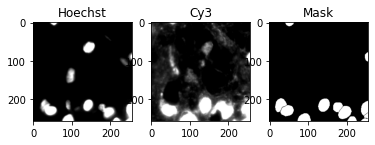

In [8]:
data = next(iter(dataset))

A = tensor2im(data["A"])
B = tensor2im(data["B"])
json_file = Path(data["json_files"][0])
with json_file.open("r") as f:
    json_data = json.load(f)

plt.subplot(131)
plt.imshow(A)
plt.title("Hoechst")
plt.subplot(132)
plt.imshow(B)
plt.title("Cy3")

mask_file = Path(cfg.dataset.data_root) / get_channel_file_from_metadata(json_data, channel="CD3", mode="mask")
mask = Image.open(mask_file)
mask = np.array(mask)
mask = mask != 0

plt.subplot(133)
plt.imshow(mask, cmap="gray")
plt.title("Mask")

img = B[..., 0]

ratio = img[mask].mean() / img[~mask].mean()
ratio